# Basic knowledges about Time-Series data

1st Chapter of book

## Import Libraries

In [2]:
"""Bayesian way"""
import arviz as az
import stan

"""Basic ones"""
import polars as pl
from plotnine import *
import matplotlib.pyplot as plt
plt.show()  # for display figures after ggplot
# plt.rcParams['axes.grid'] = True
import numpy as np
import seaborn as sns
import pandas
import statsmodels.api as sm
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

## Load Data

In [3]:
# https://vincentarelbundock.github.io/Rdatasets/articles/data.html
# df = sm.datasets.get_rdataset(dataname="AirPassengers", package="datasets")
# # df = pl.DataFrame(df)
# df = pl.DataFrame(df.data)
# df.head()

url = "https://www.salesanalytics.co.jp/591h"
df = pl.read_csv(url)
df = df.with_columns(pl.col("Month").str.strptime(pl.Date, "%Y-%m-%d"))
df = df.rename({"Month": "time", "Passengers": "value"})
df.head()

time,value
date,i64
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
# df.with_columns(pl.col("time").dt.year().alias("year"))

In [5]:
# just for fun to get the number of passengers in each year
df_year = df.with_columns(pl.col("time").dt.year().alias("year"))
(
    df_year
    .group_by(by="year", maintain_order=True)
    .agg(pl.col("value").sum())
    .head()
)

year,value
i32,i64
1949,1520
1950,1676
1951,2042
1952,2364
1953,2700


## Autocorrelation and Partial Autocorrelation

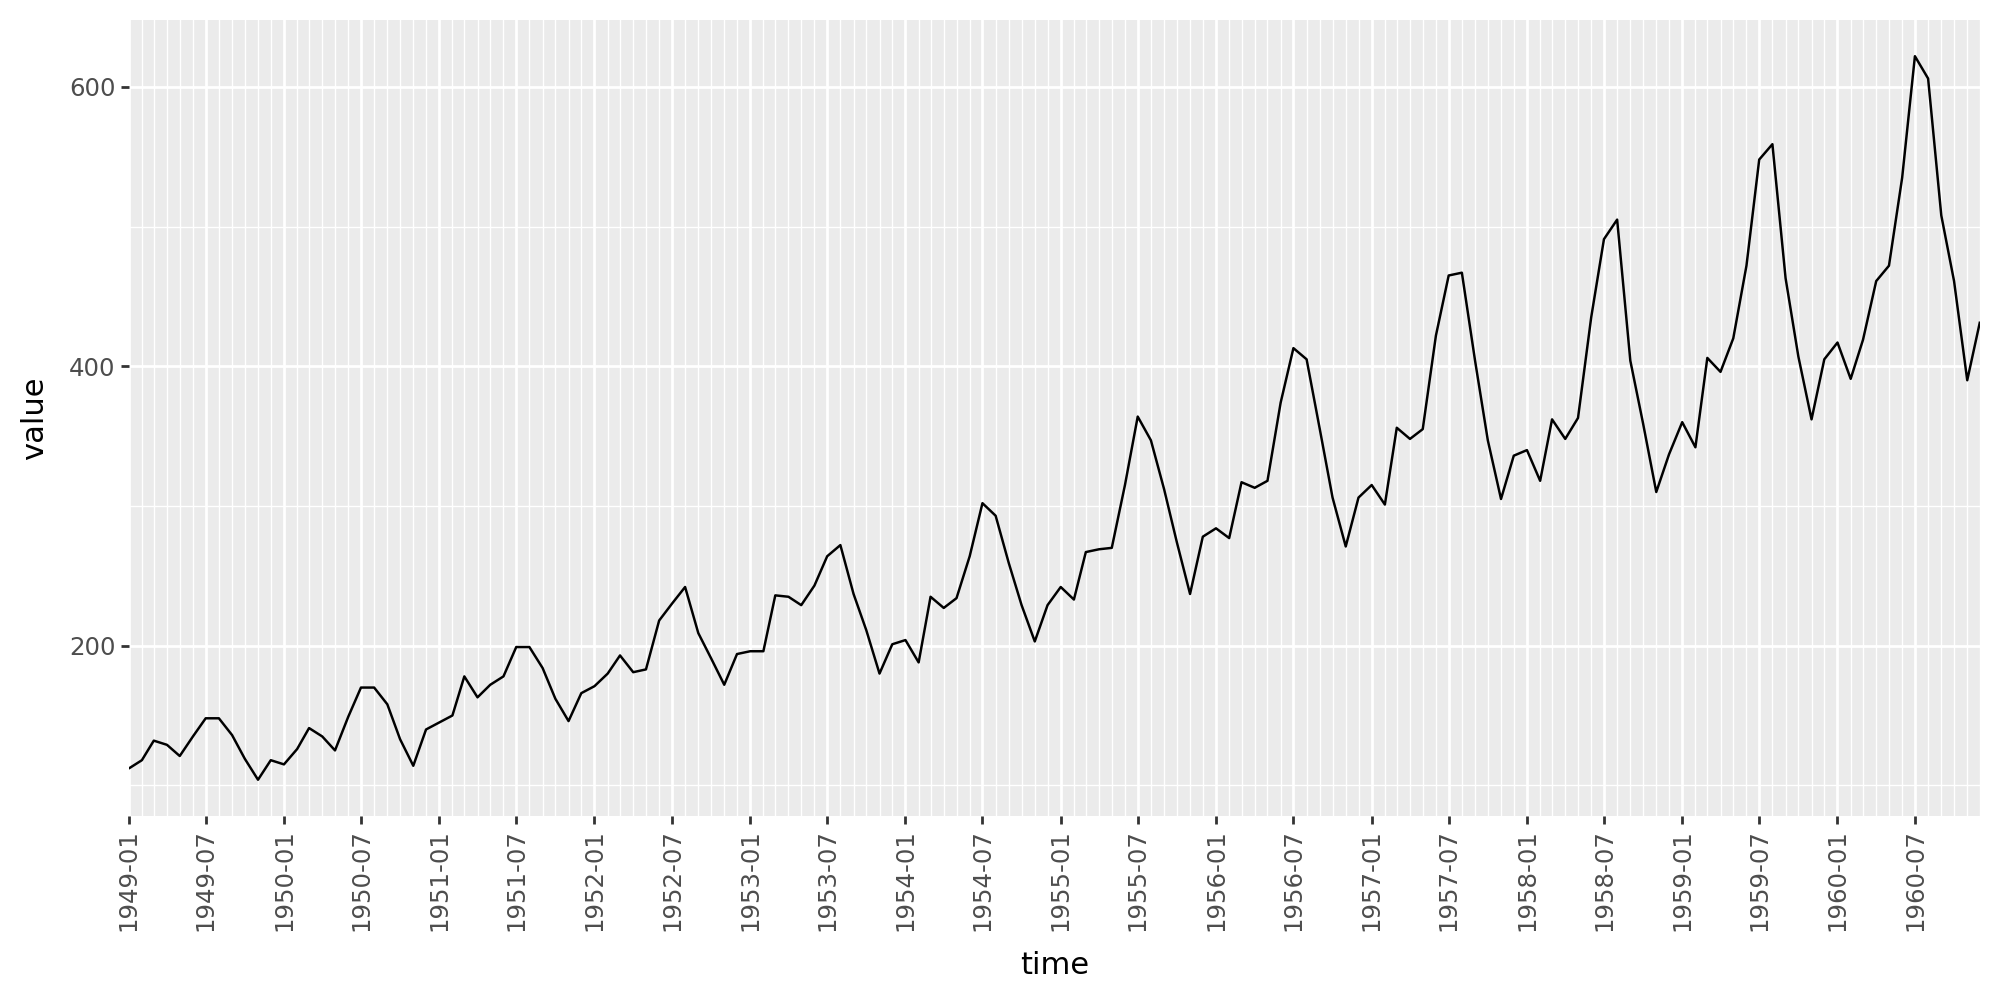

In [6]:
(
    ggplot(df, aes(x="time", y="value"))
    + geom_line()
    + theme(figure_size=(10, 5), axis_text_x=element_text(rotation=90))
    + scale_x_date(
        # set range limit
        # limits=(
        #     datetime(year=df["time"][0].year, month=1, day=1),
        #     datetime(year=df["time"][-1].year, month=12, day=1),
        # ),
        date_labels="%Y-%m",
        date_breaks="6 month",  # can't show expected scale at first and last date because the period starts from 1/1 and ends at 12/1 (not 12 month period for 1960)
        expand=(0, 0),
        date_minor_breaks="1 month",
    )
    # + geom_line(aes(x="time", y="value"), data=df[:100], color="red", size=1) # just for fun
)

There is **increasing trend** and kind of **periodic change**.

Sooo, let us see autocorrelation and partial autocorrelation to check them.

- $Cov(y_t, y_{y-k}) = E[(y_t - \mu_t)(y_{t-k} - \mu_{t-k})]$
- Autocorrelation: $Corr(y_t, y_{t-k}) = \frac{Cov(y_t, y_{y-k})}{\sqrt{Var(y_t)Var(y_{y-k})}}$
  - This is like usual correlation, but using lagged data
  - If k (lag) = 0, Autocorrelation = 1
  - 単純にｋ時点離れたところとの相関
- Partial autocorrelation: 
  - This value with k-lag can be interpreted like autocorrelation removed effect of series until t-k-1 point
  - e.g.) In case of k = 12, 各地点の11時点前までの影響が取り除かれた自己相関として解釈できる．12か月の偏自己相関を見たいときはk=13

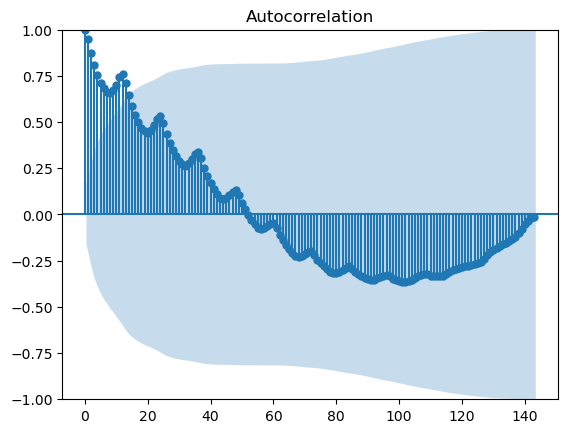

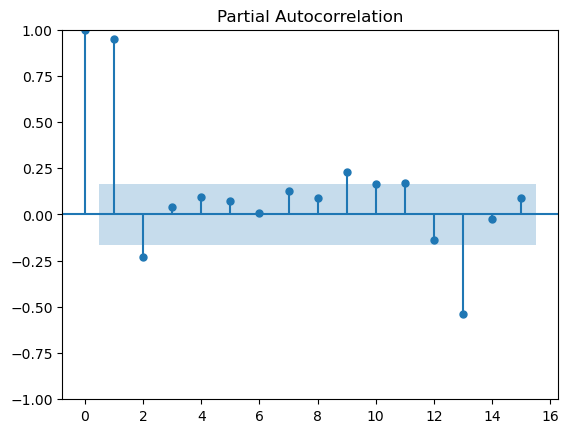

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(df["value"], lags=df.__len__()-1);
plot_pacf(df["value"], lags=15);

自己相関プロットを見ると，大体12か月周期で自己相関が大きくなっている．ここから周期の予測ができる

偏自己相関プロットを見ると大まかにk = 0, 1, 13 の地点で信頼区間を超えてる．k = 0の時はまったく同じデータだからそれは1になる．k = 1の時は前の時点の影響を考えなくていいからk = 1の自己相関と同じ値．k = 13の時は12時点前までの影響を取り除いた時の自己相関だけど，それでも周期が残ってるから...? ちょっとまだよくわからない

## White Noise and Random Walk

- White noise ($\epsilon_t$): 
  - $E(\epsilon_t) = 0$
  - $Cov(\epsilon_t, \epsilon_{t-k})\left\{ 
        \begin{alignedat}{2}   
            \sigma^2 & (k = 0) \\   
            0 & (k \neq 0)
        \end{alignedat} 
    \right.$
  - 日本語にすると，期待値は０で分散が変わらない(?)
  - 将来の情報を含まない純粋なノイズ
- iid (independent and identically distributed, 独立同一分布)
  - $y_t \sim iid(\mu, \sigma^2)$ って書く
  - White noise is iid


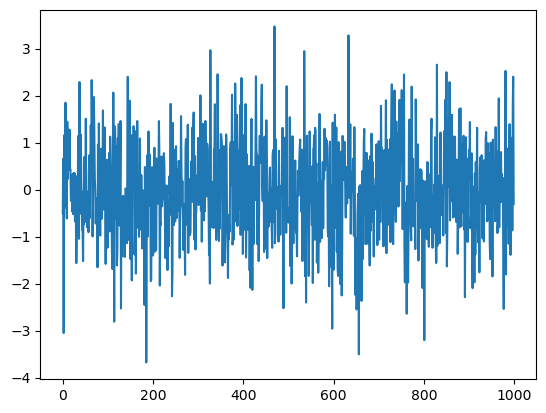

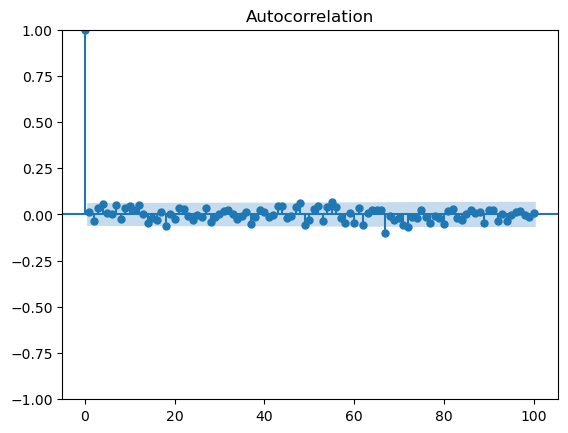

In [27]:
n = 1000
mu = 0
sigma = 1
white_noise = np.random.normal(mu, sigma, n)
plt.plot(white_noise);
plot_acf(white_noise, lags=100);

- Random Walk: 
  - $y_t = y_{t-1} + \epsilon_t, (\epsilon_t \sim iid(0, \sigma^2))$
  - ランダムウォークは非定常過程として知られる．ランダムウォークはホワイトノイズの累積和，つまり差分をとれば定常過程になる．

Text(0.5, 1.0, 'Took diff')

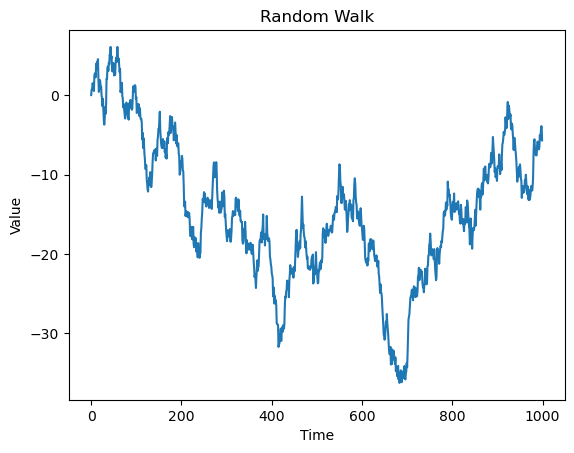

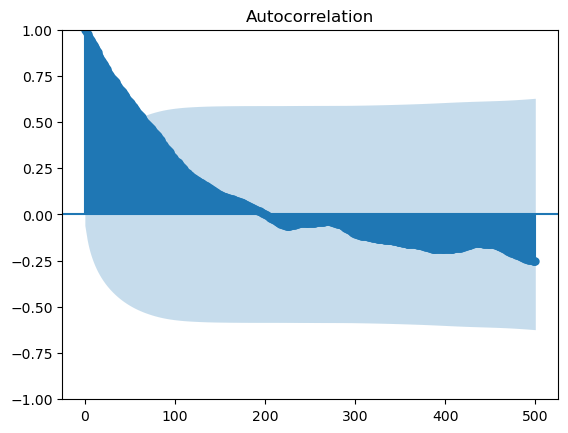

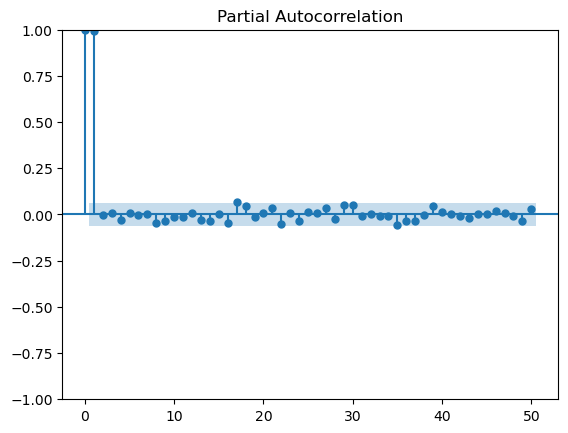

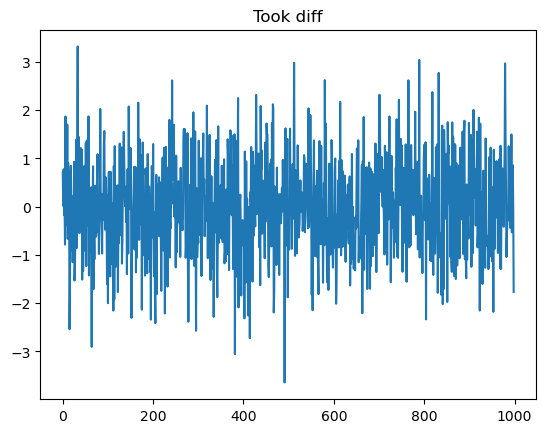

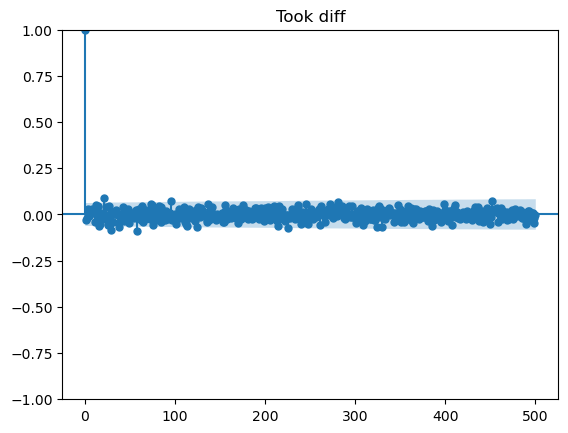

In [51]:
n = 1000
x0 = 0
noise = np.random.normal(0, 1, n)

random_walk = np.zeros(n)
random_walk[0] = x0

for i in range(1, n):
    random_walk[i] = random_walk[i - 1] + noise[i]
    
plt.plot(random_walk);
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Random Walk");
plot_acf(random_walk, lags=500);
plot_pacf(random_walk, lags=50);

random_walk_diff = np.diff(random_walk, 1)
plt.figure(); plt.plot(random_walk_diff); plt.title("Took diff")
plot_acf(random_walk_diff, lags=500); plt.title("Took diff")